In [23]:
import pandas as pd
import os
from transformers import AutoTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import math

from sentence_transformers import SentenceTransformer, InputExample, losses, models
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader
from sacrebleu.metrics import BLEU

## Dataset

In [2]:
def load_dataset(lang):
    def remove_nan(df):
        res = df.dropna()
        return res, df.shape[0] - res.shape[0]
    
    train_df, train_miss = remove_nan(pd.read_csv(f"data/{lang}/train.csv"))
    test_df, test_miss = remove_nan(pd.read_csv(f"data/{lang}/test.csv"))
    all_miss = train_miss + test_miss
    if all_miss:
        print(f"W: {all_miss} rows with missing values")
    return train_df, test_df

In [3]:
def load_samples(lang, gold_column="segreference"):
    train_df, test_df = load_dataset(lang)
    
    # normalize scores to [0, 1]
    minimum = min(np.min(train_df.raw_score), np.min(test_df.raw_score))
    maximum = max(np.max(train_df.raw_score), np.max(test_df.raw_score))
    train_df["score"] = [(rs - minimum) / (maximum - minimum) for rs in train_df.raw_score]
    test_df["score"] = [(rs - minimum) / (maximum - minimum) for rs in test_df.raw_score]
    
    train_samples = []
    test_samples = []
    
    for df, samples in [(train_df, train_samples), (test_df, test_samples)]:
        for _, row in df.iterrows():
            input_example = InputExample(texts=[row[gold_column], row.segpredict], label=row.score)
            samples.append(input_example)
            
    return train_samples, test_samples

In [17]:
train_df, test_df = load_dataset("en")
train_df.head()

W: 4 rows with missing values


,setid,docid,origlang,trglang,segid,segsource,segreference,segpredict,sysid,raw_score,z_score
0,newstestB2020,salzburg.com.254713,de,en,1,Brand in französischem Chemiewerk gelöscht,Fire in French chemical plant extinguished,Fire in French chemical plant extinguished,Human-B.0,76.0,0.019485
1,newstestB2020,salzburg.com.254713,de,en,1,Brand in französischem Chemiewerk gelöscht,Fire in French chemical plant extinguished,Fire extinguished in French chemical plant,WMTBiomedBaseline.387,100.0,0.983309
2,newstestB2020,salzburg.com.254713,de,en,1,Brand in französischem Chemiewerk gelöscht,Fire in French chemical plant extinguished,Fire extinguished in French chemical plant,OPPO.1360,100.0,2.216730
3,newstestB2020,salzburg.com.254713,de,en,1,Brand in französischem Chemiewerk gelöscht,Fire in French chemical plant extinguished,Brand in French chemistry,zlabs-nlp.1153,31.0,-1.833301
4,newstestB2020,salzburg.com.254713,de,en,1,Brand in französischem Chemiewerk gelöscht,Fire in French chemical plant extinguished,Fire extinguished in French chemical plant,Huoshan_Translate.789,100.0,0.707151


In [43]:
def compute_bleu_scores(df):
    bleu = BLEU(effective_order=True)
    df["bleu"] = [bleu.sentence_score(hyp, [ref]).score for (hyp, ref) in zip(df.segpredict, df.segreference)]

In [44]:
compute_bleu_scores(train_df)
compute_bleu_scores(test_df)

In [47]:
np.corrcoef(test_df.raw_score, test_df.bleu)

array([[1.        , 0.38398194],
       [0.38398194, 1.        ]])

## Segment analysis

W: 4 rows with missing values


100%|███████████████████████████████████████████| 15176/15176 [00:07<00:00, 2110.39it/s]


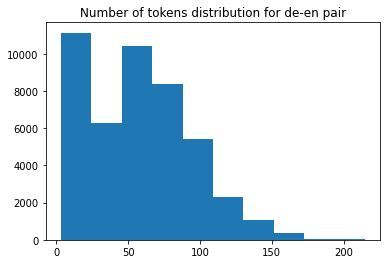

100%|███████████████████████████████████████████| 28077/28077 [00:10<00:00, 2567.39it/s]


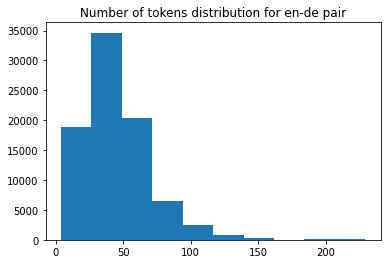

In [5]:
EN_PRETRAINED = "bert-base-uncased"
DE_PRETRAINED = "dbmdz/bert-base-german-uncased"

tokenizer_en = AutoTokenizer.from_pretrained(EN_PRETRAINED)
tokenizer_de = AutoTokenizer.from_pretrained(DE_PRETRAINED)

for lp, src_tokenizer, tgt_tokenizer in [
    ("de-en", tokenizer_de, tokenizer_en), ("en-de", tokenizer_en, tokenizer_de)
]:
    df, _ = load_dataset(lp[-2:])
    lens = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        lens.append(len(src_tokenizer(row.segsource)["input_ids"]))
        for column in ["segreference", "segpredict"]:
            lens.append(len(tgt_tokenizer(row[column])["input_ids"]))
    plt.title(f"Number of tokens distribution for {lp} pair")
    plt.hist(lens)
    plt.show()

## Sentence Transformer

In [6]:
LANG = "en"
GOLD_COLUMN = "segreference"
MODEL_NAME = "bert-base-uncased"
BATCH_SIZE = 16
NUM_EPOCHS = 5
MODEL_SAVE_PATH = (
    f"checkpoints/{LANG}-{GOLD_COLUMN}--" + MODEL_NAME + "--" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
)

print(MODEL_SAVE_PATH)

checkpoints/en-segreference--bert-base-uncased--2022-01-24_21-35-47


In [7]:
word_embedding_model = models.Transformer(MODEL_NAME, max_seq_length=100)
pooling_model = models.Pooling(768)
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
train_samples, test_samples = load_samples(LANG, gold_column=GOLD_COLUMN)
train_loader = DataLoader(train_samples, shuffle=True, batch_size=BATCH_SIZE)
train_loss = losses.CosineSimilarityLoss(model=model)
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name=f"{LANG}-{GOLD_COLUMN}-test")
warmup_steps = math.ceil(len(train_loader) * NUM_EPOCHS * 0.1)  # 10% of train data for warm-up

W: 4 rows with missing values


In [9]:
model.fit(
    train_objectives=[(train_loader, train_loss)],
    evaluator=evaluator,
    epochs=NUM_EPOCHS,
    evaluation_steps=500,
    warmup_steps=warmup_steps,
    output_path=MODEL_SAVE_PATH
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/949 [00:00<?, ?it/s]

Iteration:   0%|          | 0/949 [00:00<?, ?it/s]

Iteration:   0%|          | 0/949 [00:00<?, ?it/s]

Iteration:   0%|          | 0/949 [00:00<?, ?it/s]

Iteration:   0%|          | 0/949 [00:00<?, ?it/s]

In [22]:
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(train_samples, name=f"{LANG}-{GOLD_COLUMN}-train")
evaluator(model, output_path=MODEL_SAVE_PATH)

0.6643429878636556